Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

# Installation

1. Install h5, with `python3 -m pip install h5py`
1. Download the three h5 files: [generator](https://github.com/jennselby/MachineLearningTutorials/raw/master/generator.h5), [discriminator](https://github.com/jennselby/MachineLearningTutorials/raw/master/discriminator.h5), and [combined](https://github.com/jennselby/MachineLearningTutorials/raw/master/combined.h5) and save them in the same folder as this file.

### If you haven't already installed Keras, follow these directions

1. Type `python3 --version` into Terminal. If the output starts with "Python 3.6", skip to step 3. **Tensorflow does not yet work with Python 3.7, so you _must_ get Python 3.6.** See https://github.com/tensorflow/tensorflow/issues/20517 for updates on 3.7 support.
1. Go to https://www.python.org/downloads/ and click on "Python 3.6.8". Scroll down to the Files section and click on "macOS 64-bit installer". Run the installer and follow the directions. Repeat step 1 to make sure it has successfully installed. 
1. Set up Jupyter Notebook
    * If you had already previously installed juypter notebook with Python 3.7:
        1. Install ipykernel in Python 3.6. (_Make sure python3 is actually Python 3.6_!)
            >`python3 -m pip install ipykernel`
        1. Add this kernel as an option for your jupyter notebook:
            >`python3 -m ipykernel install --user --name python-3-6 --display-name "Python 3.6"`
    * Otherwise install jupyter notebook by typing the following into Terminal:
        >`pip3 install jupyter`
1. Start the jupyter notebook by typing in Terminal _in the same folder that you have this file_ 
    `jupyter notebook`
    1. This should open a tab in your web browser with a list of files in the folder. Click on this ipynb file to open it.
    1. If you installed a second kernel in step 3, go to the Kernel menu and choose "Change Kernel" and then select Python 3.6
1. Install the tensorflow machine learning library by typing the following into Terminal:
    >`python3 -m pip install --upgrade tensorflow`
1. Install the keras machine learning library by typing the following into Terminal:
    >`python3 -m pip install keras`
1. Install the libraries we'll need to display the images:
    > `python3 -m pip numpy matplotlib`
1. Test that the keras install worked: Type `python3` into the Terminal. When the `>>>` prompt comes up, type `from keras.models import Sequential`. If you don't get any error output, then it worked. Type Ctrl+d (or close the window) to exit.
    * If you get an error like `ModuleNotFoundError: No module named 'theano'` then you need to switch the backend to tensorflow. See the instructions at https://keras.io/backend/ or ask me for help.
    * If you get a warning like `/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6` you can ignore it. This is a known (trivial) issue with Tensorflow 1.4 for OSX. See https://github.com/tensorflow/tensorflow/issues/14182 if you'd like more details.

In [92]:
%matplotlib inline

In [93]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

In [94]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 85 
img_cols = 64
channels = 3
noise_len = 100

In [95]:
## * My Excercise One Code * 

In [103]:
#Goal is creating creating GAN on a new dataset
from PIL import Image 
from scipy import misc
import glob
import numpy 
import imageio
import glob
import matplotlib

numpy_array = []
for im_path in glob.glob("/../.../../GAN-Facebook-Resized/*.jpg"):
     im = imageio.imread(im_path)
     np_im = numpy.array(im)
     numpy_array.append(np_im)
numpy_array = numpy.array(numpy_array)
print(numpy_array)
#TODO: Implement Pillow toconvert image to numpy array
print(numpy_array.shape) #Shape of array
matplotlib.pyplot.imshow(numpy_array[0])

[]
(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

## Define functions for creating, training, and using the models

In [98]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same")) #What does kernel_size and stride do?
    model.add(LeakyReLU(alpha=0.2)) #What does alpha do?
    model.add(Dropout(0.25)) #TODO: What does dropout do?
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1)))) #TODO: What does Zeropadding and padding do?
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len,)

    model = Sequential()
    #TODO: Convert Size 
    model.add(Dense(128 * 85 * 64, activation="relu", input_shape=noise_shape)) #Creating a set of nodes which is 128 * 7 * 7 amount of nodes
    model.add(Reshape((85, 64, 128))) #This reshapes the nodes passed in from the last line and makes it have 128 nodes with a 7 by 7 output
    model.add(BatchNormalization(momentum=0.8)) #This reshapes the weights by multiplying it by 0.8
    #Research UpSampling2D 
    #model.add(UpSampling2D()) #This mutiplies the 7 by 7 output of numbers from the last line by 2 (So now the output is 14by14)
    model.add(Conv2D(128, kernel_size=3, padding="same")) #What does Conv2D do?
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8)) 
    #model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    return model
def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, epoch):
    '''
    Has the generator create images and saves the images in a single file that includes
    the epoch in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        epoch: the epoch number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='rgb')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(epoch)))
    plt.close()

def train(generator, discriminator, combined, epochs, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    epochs: integer, the number of epochs to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current epoch % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    X_train = numpy_array

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if epoch % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(epoch, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, epoch)
            
def show_new_image(generator):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (1, noise_len)) # TODO: What does noise_len do?
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

## This is the main section of the code, that actually creates the model objects

With the parameters below, the model training took almost 14 hours on my laptop.

In [99]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [100]:
# Uncomment if you want to build your own new models
generator, discriminator, combined = build_combined()

In [101]:
# Uncomment if you want to train your model (it took almost 14 hours on my laptop)
train(generator, discriminator, combined, epochs=1000, batch_size=32, save_interval=50)

ValueError: low >= high

In [ ]:
# Uncomment to save your model files
#generator.save('generator.h5')
#discriminator.save('discriminator.h5')
#combined.save('combined.h5')

**Make sure that you have downloaded the three h5 files before running the next block.**

Download the three h5 files: [generator](https://github.com/jennselby/MachineLearningTutorials/raw/master/generator.h5), [discriminator](https://github.com/jennselby/MachineLearningTutorials/raw/master/discriminator.h5), and [combined](https://github.com/jennselby/MachineLearningTutorials/raw/master/combined.h5) and save them in the same folder as this file.

In [32]:
# Load the saved model files. Comment out (or don't run) this block if you want to start
# with fresh models.
from keras.models import load_model

generator = load_model('/Users/yasnara/Documents/Coding/Machine-Learning/Machine-Learning-Portfolio/Advanced-ML/GAN/generator.h5')
discriminator = load_model('/Users/yasnara/Documents/Coding/Machine-Learning/Machine-Learning-Portfolio/Advanced-ML/GAN/discriminator.h5')
combined = load_model('/Users/yasnara/Documents/Coding/Machine-Learning/Machine-Learning-Portfolio/Advanced-ML/GAN/combined.h5')

/Users/yasnara/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Let's see how it worked, by having the model generate some images for us.

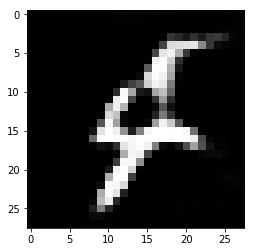

In [33]:
show_new_image(generator)

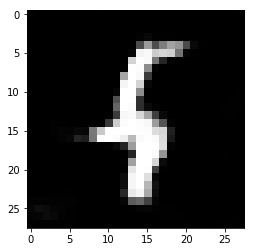

In [34]:
show_new_image(generator)

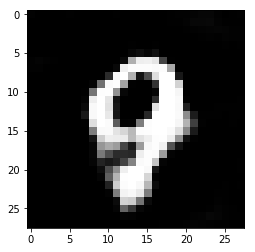

In [35]:
show_new_image(generator)

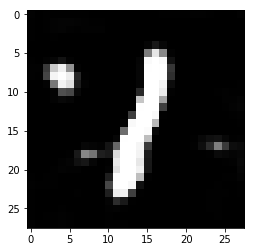

In [36]:
show_new_image(generator)